# Model Evaluation, Scarcity, Abundance of Data

# Reading the data

In [3]:
df = pd.read_csv("data/income_data.csv")

In [4]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0


In [5]:
cat_columns = ['sex', 'education', 'race']
cont_columns = ['age', 'education-num', 'hours-per-week']
features = cat_columns + cont_columns
target = "target"

# Building the first pipeline

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [184]:
cat_trans = Pipeline(steps=[('onehot', OneHotEncoder(drop='first',
                                                     min_frequency=0.05,
                                                    handle_unknown='infrequent_if_exist'))])
cont_trans = Pipeline(steps=[('scaler', StandardScaler())])

feat_trans = ColumnTransformer(
    transformers=[('categorical', cat_trans, cat_columns),
                  ('continuous', cont_trans, cont_columns)])

def mk_knn(k):
    return Pipeline(steps=[
        ('feature_transform', feat_trans),
        ('classifier', KNeighborsClassifier(n_neighbors=k))
    ])

def mk_tree(d):
    return Pipeline(steps=[
        ('feature_transform', feat_trans),
        ('classifier', DecisionTreeClassifier(max_depth=d))
    ])

In [185]:
mk_tree(3)

Pipeline(steps=[('feature_transform',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.05))]),
                                                  ['sex', 'education', 'race']),
                                                 ('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'education-num',
                                                   'hours-per-week'])])),
                ('classifier', DecisionTreeClassifier(max_depth=3))])

## K-fold Cross-validation

In [186]:
from sklearn.model_selection import cross_val_score

In [187]:
cv_scores = cross_val_score(mk_tree(5), df[features], df[target], cv=50)

In [188]:
cv_scores

array([0.80368098, 0.80214724, 0.7898773 , 0.79907975, 0.81441718,
       0.82055215, 0.79907975, 0.79601227, 0.80368098, 0.79754601,
       0.81441718, 0.80645161, 0.83563748, 0.8187404 , 0.8156682 ,
       0.78494624, 0.78801843, 0.80337942, 0.80184332, 0.80645161,
       0.8218126 , 0.80645161, 0.81259601, 0.83102919, 0.78648233,
       0.8141321 , 0.82642089, 0.8187404 , 0.79877112, 0.78955453,
       0.80645161, 0.8141321 , 0.79877112, 0.80645161, 0.80491551,
       0.82949309, 0.8141321 , 0.82488479, 0.81259601, 0.8156682 ,
       0.80952381, 0.80184332, 0.80337942, 0.82642089, 0.81259601,
       0.81259601, 0.80030722, 0.80491551, 0.79877112, 0.78801843])

<AxesSubplot:ylabel='Count'>

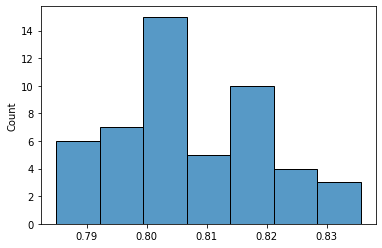

In [189]:
sns.histplot(cv_scores)

## Stratified K-Fold

In [222]:
from sklearn.model_selection import StratifiedKFold, KFold

In [223]:
cv_scores_strat = cross_val_score(mk_tree(5), df[features], df[target], cv=StratifiedKFold(n_splits=50))

<AxesSubplot:ylabel='Count'>

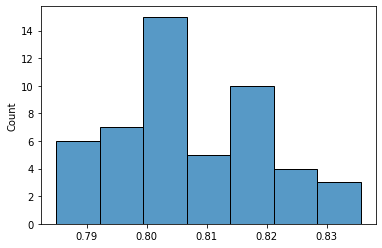

In [224]:
sns.histplot(cv_scores_strat)

In [225]:
cv_scores = cross_val_score(mk_tree(5), df[features], df[target], cv=KFold(n_splits=50))

<AxesSubplot:ylabel='Count'>

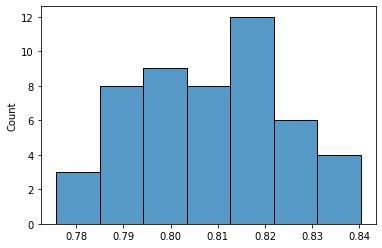

In [226]:
sns.histplot(cv_scores)

<AxesSubplot:ylabel='Count'>

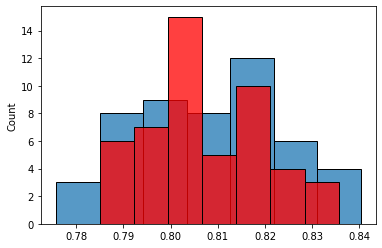

In [227]:
sns.histplot(cv_scores)
sns.histplot(cv_scores_strat, color='red')

# If there was no time last lecture: Shooting yourself in the foot - correct use of pipelines

In [1]:
from sklearn.linear_model import LogisticRegression

In [229]:
import numpy

In [230]:
k, N = 5000, 500

In [231]:
X = numpy.random.rand(k*N).reshape(N, k)

In [232]:
y = numpy.random.choice([0, 1], N)

In [233]:
from sklearn.feature_selection import SelectKBest

In [234]:
Xp = SelectKBest(k=10).fit_transform(X, y)

In [235]:
import seaborn as sns

In [236]:
cv_scores = pd.DataFrame({
    'full data': cross_val_score(LogisticRegression(max_iter=10_000), X, y, cv=20),
    'selected features': cross_val_score(LogisticRegression(max_iter=10_000), Xp, y, cv=20)}
)

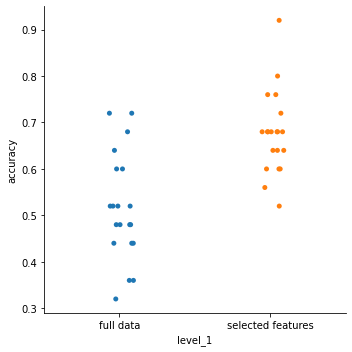

In [237]:
sns.catplot(data=cv_scores.stack().reset_index(name='accuracy'), x='level_1', y='accuracy')

## The right way

In [252]:
from sklearn.feature_selection import SelectKBest

In [256]:
def mk_knn_fs(k):
    return Pipeline(steps=[
        ('feature_transform', feat_trans),
        ('feature_select', SelectKBest(k=10)),
        ('classifier', KNeighborsClassifier(n_neighbors=k))
    ])

In [257]:
mk_knn_fs(20)

Pipeline(steps=[('feature_transform',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.05))]),
                                                  ['sex', 'education', 'race']),
                                                 ('continuous',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'education-num',
                                                   'hours-per-week'])])),
                ('feature_select', SelectKBest()),
                ('classifier', KNeighborsClassifier(n_neighbors=20))])

<AxesSubplot:>

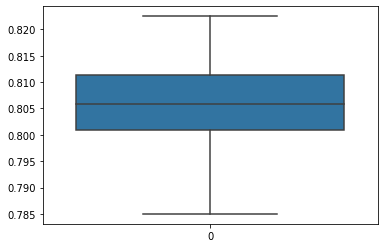

In [261]:
sns.boxplot(data=cross_val_score(mk_knn_fs(20), df[features], df[target], cv=20))

## Reproducibility - When using shuffle split

In [238]:
from sklearn.model_selection import ShuffleSplit

In [243]:
cross_val_score(mk_knn(10), df[features], df[target], cv=ShuffleSplit(random_state=42))

array([0.79889469, 0.80288609, 0.80165797, 0.7881486 , 0.80227203,
       0.79521032, 0.79889469, 0.79244704, 0.79551735, 0.80257906])

## With scarse data: Leave-one-out

In [190]:
from sklearn.model_selection import LeaveOneOut

In [201]:
df_red = df.sample(100)

In [202]:
loo_cv = cross_val_score(mk_tree(3), df_red[features], df_red[target], cv=LeaveOneOut())

/Users/DIRH/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/DIRH/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/DIRH/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [203]:
loo_cv.mean()

0.6

In [207]:
loo_cv

array([1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
       0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1.])

In [215]:
import scipy
import matplotlib.pyplot as plt

In [245]:
k, n = loo_cv.sum(), loo_cv.shape[0]

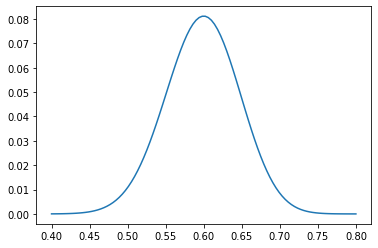

In [251]:
ps=numpy.linspace(0.4, 0.8, 100)
plt.plot(ps, scipy.stats.binom.pmf(k=k, n=n, p=ps))

In [1]:
import pandas
import numpy
from scipy.stats import binom
import matplotlib.pyplot as plt


url = ('https://github.com/dhesse/IN-STK5000-Autumn21'
       '/raw/main/compas-scores-two-years.csv.gz')
data = pandas.read_csv(url) # load the data
data.groupby('age_cat')['two_year_recid'].mean() # point estimate

age_cat
25 - 45            0.459723
Greater than 45    0.315990
Less than 25       0.565075
Name: two_year_recid, dtype: float64

<AxesSubplot:ylabel='Frequency'>

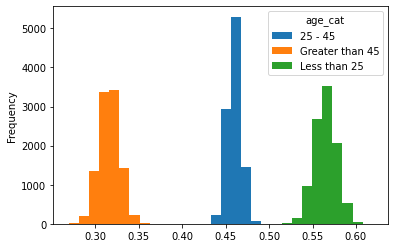

In [14]:
bss = pandas.DataFrame([
    data.sample(data.shape[0], replace=True).
        groupby('age_cat')['two_year_recid'].mean()
    for _ in range(10000)])
bss.plot.hist(bins=30)

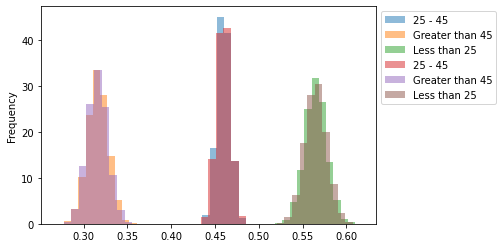

In [16]:
params = pandas.DataFrame({
    'N': data.groupby('age_cat').size(),
    'k': data.groupby('age_cat')['two_year_recid'].sum(),
})
binomial = params.apply(
    lambda x: binom.rvs(x['N'], # make a model and draw samples
                        x['k']/x['N'],
                        size=5000)/x['N'], axis=1, result_type='expand').T
ax = binomial.plot.hist(bins=40, density=True, alpha=0.5)
bss.plot.hist(bins=40, ax=ax, density=True, alpha=0.5)
plt.legend(bbox_to_anchor=(1,1))

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [19]:
Xtr, Xte, ytr, yte = train_test_split(data[['age_cat']], data['two_year_recid'], test_size=0.2)

In [21]:
ytr.groupby(Xtr['age_cat']).mean()

age_cat
25 - 45            0.463689
Greater than 45    0.317422
Less than 25       0.565822
Name: two_year_recid, dtype: float64

In [22]:
pred = Xte['age_cat'] == 'Less than 25'

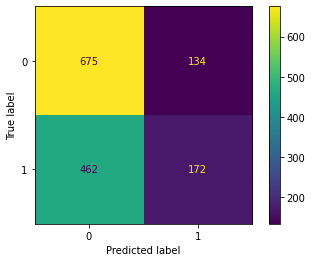

In [35]:
ConfusionMatrixDisplay(confusion_matrix(yte, pred)).plot()

In [37]:
confusion_matrix(yte, pred)

array([[675, 134],
       [462, 172]])

In [48]:
X = pandas.get_dummies(data[['age_cat', 'priors_count']])
y = data['two_year_recid']

In [49]:
import numpy

In [72]:
cms = []
for _ in range(1000):
    idx = numpy.random.choice(len(y), len(y), True)
    Xtr, Xte, ytr, yte = train_test_split(X.iloc[idx], y.iloc[idx], test_size=0.2)
    model = DecisionTreeClassifier(max_depth=2).fit(Xtr, ytr)
    cms.append(confusion_matrix(yte, model.predict(Xte), normalize='true'))

In [69]:
from itertools import product

In [70]:
labels = [['tnr', 'fnr'], ['fpr', 'tpr']]

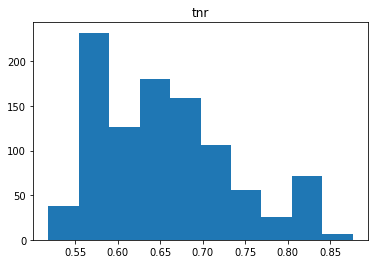

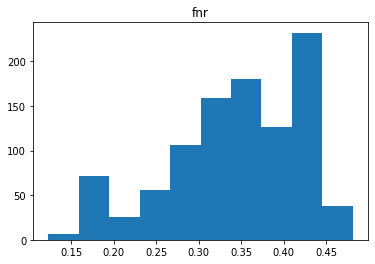

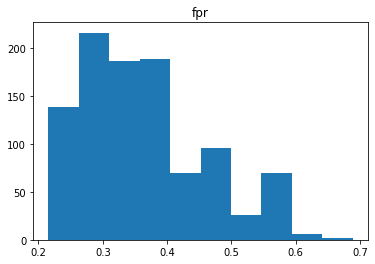

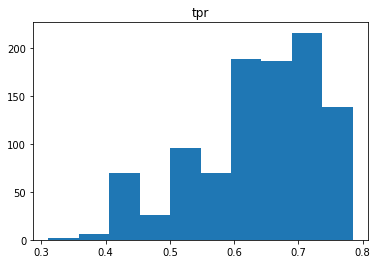

<Figure size 432x288 with 0 Axes>

In [73]:
for i, j in product([0,1], repeat=2):
    plt.hist([c[i,j] for c in cms])
    plt.title(labels[i][j])
    plt.figure()

In [1]:
import pandas
import numpy
from scipy.stats import binom
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

In [2]:
url = ('https://github.com/dhesse/IN-STK5000-Autumn21'
       '/raw/main/compas-scores-two-years.csv.gz')
data = pandas.read_csv(url)

In [1]:
import pandas as pd

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [42]:
features = ['age', 'juv_misd_count', 'priors_count']
target = 'two_year_recid'
X = data[features]
y = data[target]
cross_val_score(DecisionTreeClassifier(max_depth=5), X, y)

array([0.6950797 , 0.67290367, 0.63270963, 0.6950797 , 0.67822469])

In [43]:
model = DecisionTreeClassifier(max_depth=5).fit(X, y)

In [44]:
model.predict_proba([[30, 3, 0]])[0][0]

0.716304347826087

In [40]:
models = []
for _ in range(1000):
    sample = data.sample(data.shape[0], replace=True)
    models.append(DecisionTreeClassifier(max_depth=5).fit(sample[features], sample[target]))

(array([ 15.,  38., 101., 259., 263., 167.,  87.,  38.,  10.,   4.,   2.,
          0.,   0.,   0.,   0.,   3.,   3.,   0.,   0.,  10.]),
 array([0.65319426, 0.67053455, 0.68787484, 0.70521512, 0.72255541,
        0.7398957 , 0.75723598, 0.77457627, 0.79191656, 0.80925684,
        0.82659713, 0.84393742, 0.86127771, 0.87861799, 0.89595828,
        0.91329857, 0.93063885, 0.94797914, 0.96531943, 0.98265971,
        1.        ]),
 <BarContainer object of 20 artists>)

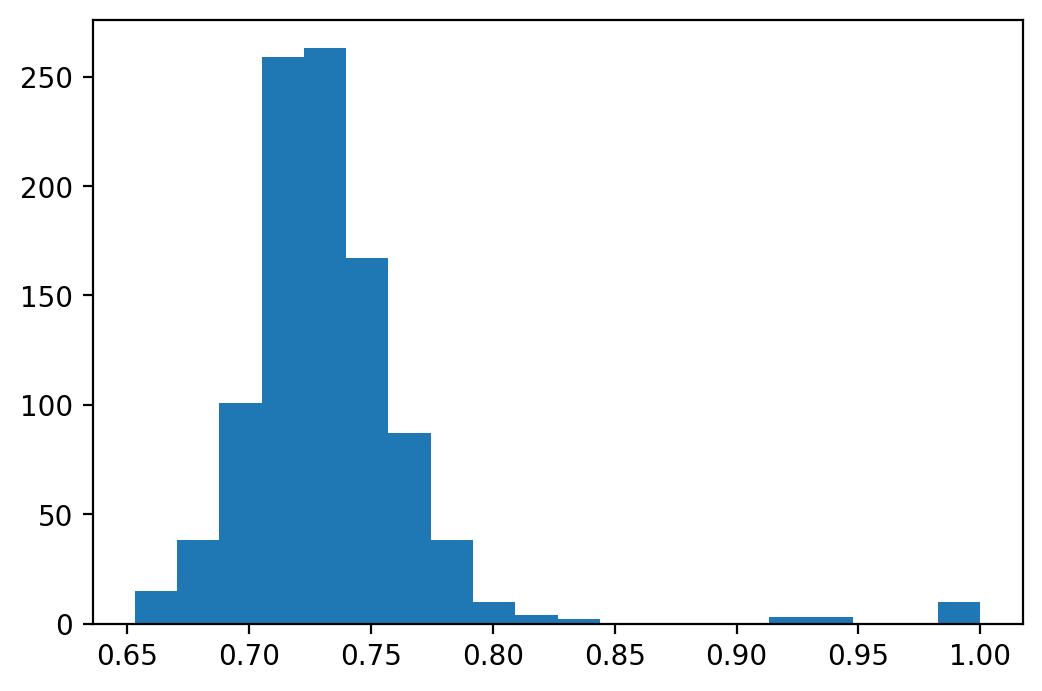

In [41]:
plt.hist([m.predict_proba([[30, 3, 0]])[0][0] for m in models], bins=20)

## Model selection

In [56]:
# look for good value for k in kNN model

def knn_score(k):
    return sklearn.metrics.accuracy_score(
        yte, mk_knn(k).fit(Xtr, ytr).predict(Xte)
    )

In [57]:
ks = range(5, 31, 5)

In [58]:
knn_scores = [knn_score(k) for k in ks]

<AxesSubplot:>

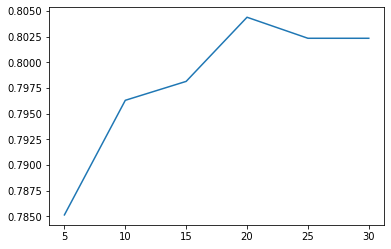

In [59]:
pd.Series(knn_scores, index=ks).plot.line()

## Using cross validation

In [60]:
ds = range(1, 15)

In [61]:
score_results = [cross_val_score(mk_tree(d), df[features], df[target], cv=5) for d in ds]

In [62]:
score_results

[array([0.75909719, 0.75921376, 0.75921376, 0.75921376, 0.75921376]),
 array([0.78120682, 0.78393735, 0.7882371 , 0.79038698, 0.78224816]),
 array([0.79594657, 0.80159705, 0.80451474, 0.80712531, 0.80175061]),
 array([0.8003992 , 0.80144349, 0.80727887, 0.80712531, 0.80451474]),
 array([0.80132044, 0.80651106, 0.8088145 , 0.81280713, 0.80558968]),
 array([0.8011669 , 0.80574324, 0.80835381, 0.81019656, 0.80528256]),
 array([0.80515891, 0.80712531, 0.8088145 , 0.81464988, 0.80681818]),
 array([0.80070628, 0.80605037, 0.80927518, 0.81096437, 0.80420762]),
 array([0.79932443, 0.80236486, 0.80927518, 0.80973587, 0.80359337]),
 array([0.79809612, 0.79914005, 0.80589681, 0.80820025, 0.80159705]),
 array([0.7968678 , 0.79898649, 0.80374693, 0.80405405, 0.8022113 ]),
 array([0.79118686, 0.79683661, 0.79929361, 0.80175061, 0.79699017]),
 array([0.78627361, 0.79284398, 0.79376536, 0.79683661, 0.79361179]),
 array([0.78243513, 0.79054054, 0.79376536, 0.79391892, 0.79437961])]

In [70]:
sr = pd.DataFrame(score_results, index=ds).T

In [71]:
sr

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.759097,0.781207,0.795947,0.800399,0.801320,0.801167,0.805159,0.800706,0.799324,0.798096,0.796868,0.791187,0.786274,0.782435
1,0.759214,0.783937,0.801597,0.801443,0.806511,0.805743,0.807125,0.806050,0.802365,0.799140,0.798986,0.796837,0.792844,0.790541
2,0.759214,0.788237,0.804515,0.807279,0.808814,0.808354,0.808814,0.809275,0.809275,0.805897,0.803747,0.799294,0.793765,0.793765
3,0.759214,0.790387,0.807125,0.807125,0.812807,0.810197,0.814650,0.810964,0.809736,0.808200,0.804054,0.801751,0.796837,0.793919
4,0.759214,0.782248,0.801751,0.804515,0.805590,0.805283,0.806818,0.804208,0.803593,0.801597,0.802211,0.796990,0.793612,0.794380


<AxesSubplot:>

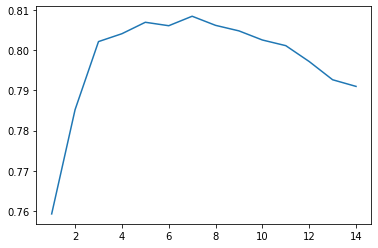

In [73]:
sr.mean().plot.line()

In [65]:
import matplotlib.pyplot as plt

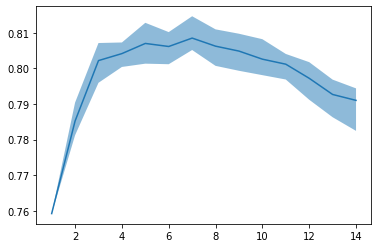

In [75]:
sr.mean().plot.line()
plt.fill_between(ds, sr.min(), sr.max(), alpha=0.5)

# Grid Search

In [76]:
from sklearn.model_selection import GridSearchCV

In [77]:
param_grid = {'classifier__max_depth': ds}
grid_search = GridSearchCV(mk_tree(1), param_grid, cv=10)

In [78]:
fit_result = grid_search.fit(df[features], df[target])

In [80]:
fit_result.best_estimator_.get_params()

{'memory': None,
 'steps': [('feature_transform',
   ColumnTransformer(transformers=[('categorical',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(drop='first'))]),
                                    ['sex', 'education', 'race']),
                                   ('continuous',
                                    Pipeline(steps=[('scaler', StandardScaler())]),
                                    ['age', 'education-num', 'hours-per-week'])])),
  ('classifier', DecisionTreeClassifier(max_depth=7))],
 'verbose': False,
 'feature_transform': ColumnTransformer(transformers=[('categorical',
                                  Pipeline(steps=[('onehot',
                                                   OneHotEncoder(drop='first'))]),
                                  ['sex', 'education', 'race']),
                                 ('continuous',
                                  Pipeline(steps=[('scaler', Sta